<a href="https://colab.research.google.com/github/vadim-privalov/Neiroset_Novosibirsk/blob/main/Lesson_01_Introduction_to_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 style="text-align: center;"><b>Первое знакомство с YOLO</b></h1>

В этом уроке мы познакомимся с технологией YOLO для обнаружения объектов на изображениях. Разберём её принцип работы, архитектуру сети. Построим модель с оригинальными весами и протестируем её на наших примерах.

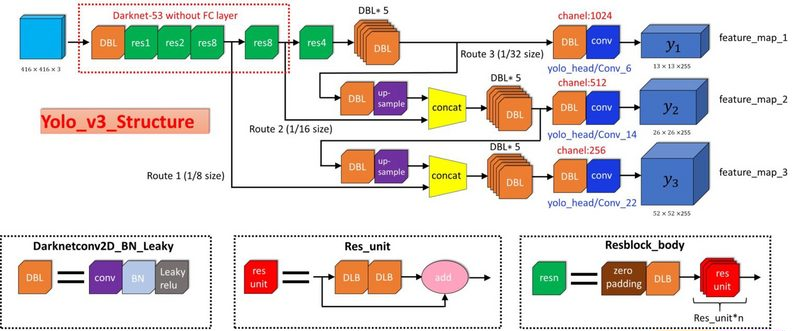

Рисунок 1. Алгоритм YOLO.

YOLO - это алгоритм обнаружения объектов в реальном времени, который идентифицирует определенные объекты в видео, прямых трансляциях или изображениях. Версии 1-3 YOLO были созданы Джозефом Редмоном и Али Фархади. Первая версия YOLO была создана в 2016 году, а версия 3, которая подробно обсуждается в этом уроке, была создана двумя годами позже, в 2018 году.

YOLO - это сверточная нейронная сеть (CNN) для обнаружения объектов. Она написана на языке Си на фреймворке Darknet. В этом уроке мы будем использовать её tensorflow имплементацию. Сеть имеет 75 cnn-слоев (сверточные слои) + 31 другие слои (ответвления, upsample) = всего 106 слоев.

Другие сопоставимые алгоритмы, которые могут выполнять ту же задачу, - это R-CNN (сверточные нейронные сети на основе регионов, созданные в 2015 году) и Fast R-CNN (усовершенствование R-CNN, разработанное в 2017 году) и Mask R-CNN . Однако, в отличие от таких систем, как R-CNN и Fast R-CNN, YOLO обучен выполнять классификацию и регрессию ограничивающего прямоугольника одновременно.

Самое большое преимущество модели YOLO, собственно, отражено в названии — You Only Look Once. Эта модель накладывает на изображение сетку, разделяя его на ячейки. Каждая ячейка пытается предсказать координаты зоны обнаружения с оценкой уверенности для этих полей и вероятностью классов. Затем оценка уверенности для каждой зоны обнаружения умножается на вероятность класса, чтобы получить окончательную оценку.

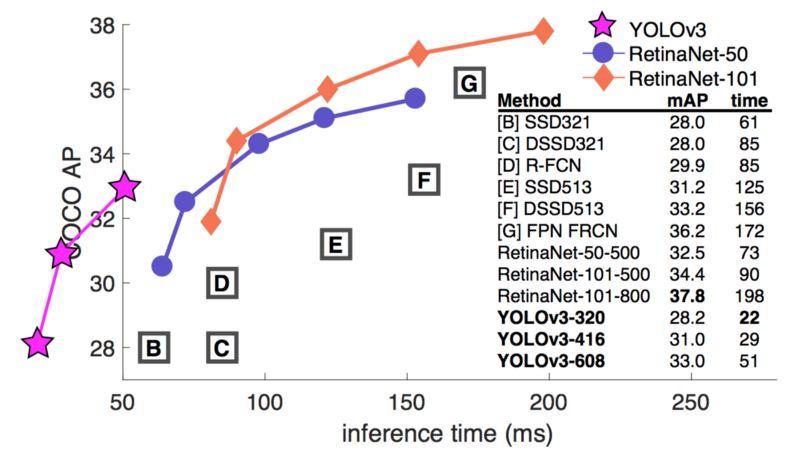

Рисунок 2. Сравнение производительности алгоритмов object detection.

Скачиваем файлы, необходимые для урока, и устанавливаем корневыую папку проекта.

In [ ]:
!wget http://dataudt.ru/datasets/cv/Lesson_01.Introduction_to_Yolo.zip
!unzip -qq Lesson_01.Introduction_to_Yolo.zip
%cd /content/Lesson_01.Introduction_to_Yolo/

--2021-05-14 14:42:44--  http://dataudt.ru/datasets/cv/Lesson_01.Introduction_to_Yolo.zip
Resolving dataudt.ru (dataudt.ru)... 37.228.117.130
Connecting to dataudt.ru (dataudt.ru)|37.228.117.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 604175 (590K) [application/zip]
Saving to: ‘Lesson_01.Introduction_to_Yolo.zip’

Lesson_01.Introduct 100%[===================>] 590.01K   668KB/s    in 0.9s    

2021-05-14 14:42:45 (668 KB/s) - ‘Lesson_01.Introduction_to_Yolo.zip’ saved [604175/604175]

/content/Lesson_01.Introduction_to_Yolo


Скачиваем оригинальные веса модели Yolov3 с оффициального сайта.

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-05-14 14:42:46--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   102MB/s    in 2.3s    

2021-05-14 14:42:48 (102 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



Импортируем необходимые модули.

In [ ]:
# Основные модули.
import numpy as np
import cv2
import tensorflow as tf

# Функции для конструирования сети.
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D
from tensorflow.keras.regularizers import l2

# Функция для отображения изображений.
from google.colab.patches import cv2_imshow
# Модуль для преобразования между цветовыми пространствами.
import colorsys
# Генератор случайных чисел.
import random
# Функции для получения списка файлов в директории.
from os import listdir
from os.path import isfile, join

Зададим входные параметры сети.

In [ ]:
# Зададим размер входа сети.
yolo_input_size = 416
# Укажем путь, где хранятся счанные веса модели.
yolo_weights_path = "yolov3.weights"

Оригинальная сеть Yolov3 обучалась на датасете MS COCO, который состоит из 80 классов.

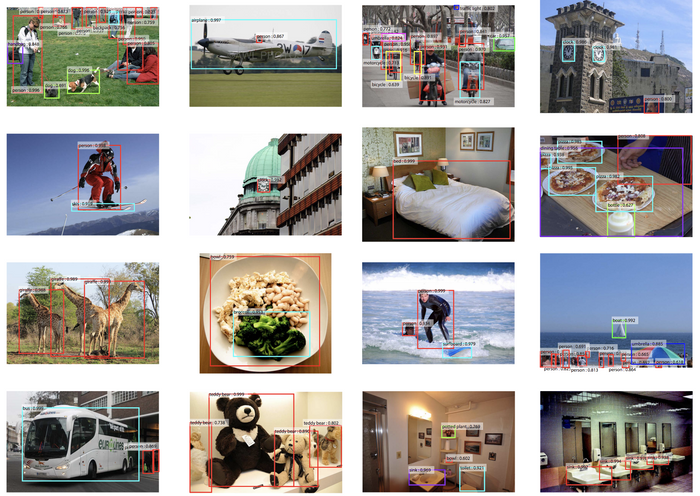

Рисунок 3. Примеры картинок из датасета MS COCO.

In [ ]:
# Создадим список классов.
class_names_list = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

# Посчитаем количество классов.
num_classes = len(class_names_list)
print('Total number of classses:', num_classes)

# Создадим словарь индексов и имён классов.
# И отобразим его.
class_names_dict = {}
for id, name in enumerate(class_names_list):
    class_names_dict [id] = name
    print('{}: {}, '.format(id, name), end='')
    if id % 5 == 0 and id != 0:
        print()
print('\b\b')

Total number of classses: 80
0: person, 1: bicycle, 2: car, 3: motorbike, 4: aeroplane, 5: bus, 
6: train, 7: truck, 8: boat, 9: traffic light, 10: fire hydrant, 
11: stop sign, 12: parking meter, 13: bench, 14: bird, 15: cat, 
16: dog, 17: horse, 18: sheep, 19: cow, 20: elephant, 
21: bear, 22: zebra, 23: giraffe, 24: backpack, 25: umbrella, 
26: handbag, 27: tie, 28: suitcase, 29: frisbee, 30: skis, 
31: snowboard, 32: sports ball, 33: kite, 34: baseball bat, 35: baseball glove, 
36: skateboard, 37: surfboard, 38: tennis racket, 39: bottle, 40: wine glass, 
41: cup, 42: fork, 43: knife, 44: spoon, 45: bowl, 
46: banana, 47: apple, 48: sandwich, 49: orange, 50: broccoli, 
51: carrot, 52: hot dog, 53: pizza, 54: donut, 55: cake, 
56: chair, 57: sofa, 58: pottedplant, 59: bed, 60: diningtable, 
61: toilet, 62: tvmonitor, 63: laptop, 64: mouse, 65: remote, 
66: keyboard, 67: cell phone, 68: microwave, 69: oven, 70: toaster, 
71: sink, 72: refrigerator, 73: book, 74: clock, 75: vase, 
76:

Используя значения якорей из файла конфигурации yolov3.cfg (ссылка на файл указана снизу в разделе литература)  

anchors = 10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326

зададим список якорей и шагов.
В сети Yolov3 используется 9 якорей,  по 3 якоря и одному шагу на выход сети.

Якоря - это начальные размеры (ширина, высота) ограничивающей рамки. С их помощью и окончательной карты признаков мы можем получить размеры ограничивающей рамки объекта.

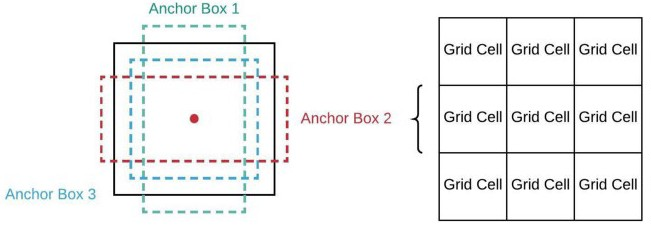

Рисунок 4. Примеры якорей.

In [ ]:
# Список шагов для каждого выхода сети.
# Размер в пикселях одной ячейки сетки 
# изображения в зависимости от выхода сети.
yolo_strides = [8, 16, 32]
# 416 / 52 = 8 пикселей 
# 416 / 26 = 16 пикселей
# 416 / 13 = 32 пикселя

# Количество якорей на каждый выход сети 
yolo_anchors_per_scale = 3

# Список якорей для каждого выхода сети.
yolo_anchors = [[[10,  13], [16,   30], [33,   23]],
                [[30,  61], [62,   45], [59,  119]],
                [[116, 90], [156, 198], [373, 326]]]

# Преобразуем списки якорей и шагов в удобную форму для использования.
yolo_strides = np.array(yolo_strides)
yolo_anchors = (np.array(yolo_anchors).T/yolo_strides).T

## Используя описание архитектуры сети из файла конфигурации зададим необходимые функции и построим сеть.

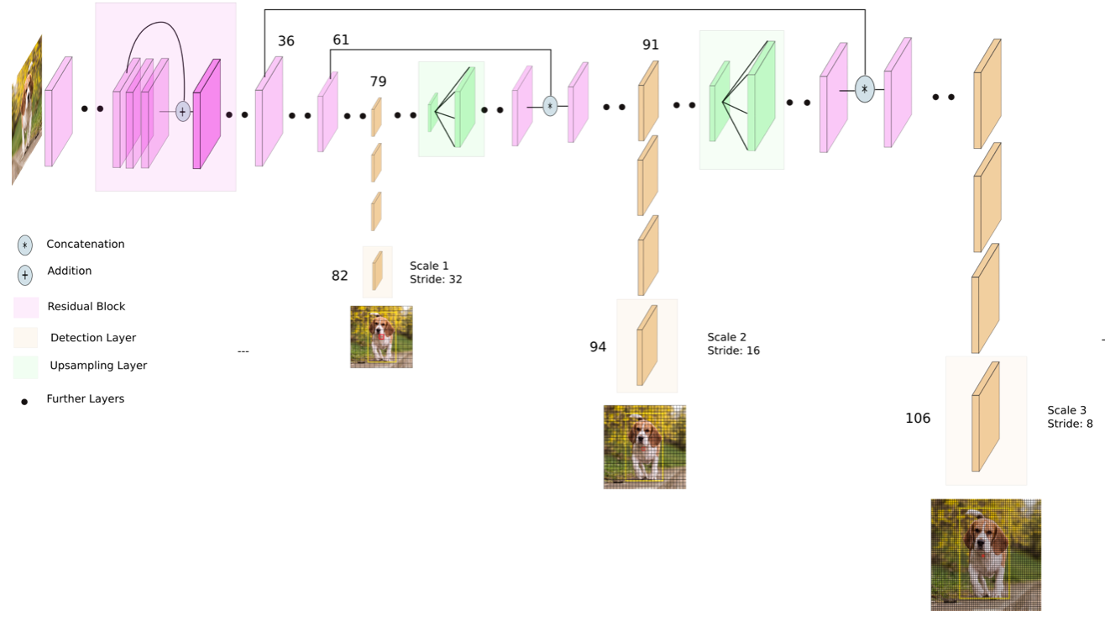

Рисунок 4. Структурная схема архитектуры сети Yolov3.

In [ ]:
# Переопределим класс пакетной нормализации.
class BatchNormalization(BatchNormalization):
    # В TensorFlow 2.0 есть особенности заморозки слоя BatchNormalization.
    # Пакетная нормализация работает по-разному во время обучения 
    # и во время вывода (predict, evaluate).
    # Чтобы не изменять внутренние обученные переменные 
    # добавим возможность заморозки значений слоя.
    def call(self, x, training=False):
        if not training:
            training = tf.constant(False)
        training = tf.logical_and(training, self.trainable)
        return super().call(x, training)

# Зададим функцию для увеличение разрешения.
def upsample(input_layer):
    # Нам нужно будет увеличивать выход слоя сети, 
    # растягивать в 2 раза по ширине и высоте.
    # Для этого будем использовать интерполяцию методом ближайшего соседа.
    # Это самый простой и быстрый метод.
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')

In [ ]:
# Зададим функцию для определения парамметров свёрточного слоя.
def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True):
    # Если уменьшение разрешения активно
    if downsample:
        # заполняем нулями сверху и слева
        # ((top_pad, bottom_pad), (left_pad, right_pad))
        input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
        padding = 'valid' # без заполнения
        strides = 2 # шаг свёртки
    else:
        strides = 1 # шаг свёртки
        padding = 'same' # заполнение до такого же размера

    # Определяем параметры свёртки.
    # filters - количество фильтров
    # kernel_size - размер ядра свёртки
    # strides - шаг ядра свёртки
    # padding - заполнение
    # use_bias - использование смещения
    # kernel_regularizer - регуляризация весов
    # kernel_initializer - инициализация весов
    # bias_initializer - инициализация весов смещения
    conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
                  padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                  bias_initializer=tf.constant_initializer(0.))(input_layer)
    
    # Если активна пакетная нормализация.
    if bn:
        conv = BatchNormalization()(conv)

    # Если нужно использовать функцию активации.
    if activate == True:
        # используется ReLU с "утечкой"
        conv = LeakyReLU(alpha=0.1)(conv)

    # Возвращаем определённый свёрточный слой.
    return conv

In [ ]:
# Зададим функцию для определения блока короткого соединения.
def residual_block(input_layer, input_channel, filter_num1, filter_num2):
    # Сохраняем значения короткого соединения на входе в блок
    short_cut = input_layer

    # Пропускаем через слои свёртки.
    # Cвёртка 1 х 1 для уменьшения размерности 
    # (свёртка 1 х 1 объединяет все каналы входных пикселей в один пиксель).
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1))
    # свёртка 3 х 3 
    conv = convolutional(conv       , filters_shape=(3, 3, filter_num1,   filter_num2))

    # Отстаточные или короткие соединения нужны для того,
    # чтобы избавится от проблемы затухания градиента
    # в глубоких сетях с большим количеством слоёв

    # Складываем значения короткого соединения с выходными значениями свёртки
    residual_output = short_cut + conv

    # Возвращаем полученный результат
    return residual_output

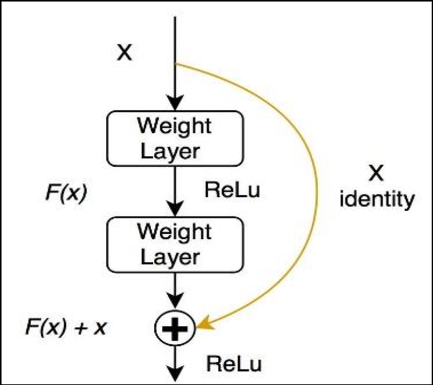

Рисунок 5. Блок короткого соединения (остаточной связи).

In [ ]:
# Зададим архитектуру сети Darknet-53.
def darknet53(input_data):
    # свёртка
    input_data = convolutional(input_data, (3, 3,  3,  32))
    # свёртка с уменьшением
    input_data = convolutional(input_data, (3, 3, 32,  64), downsample=True)

    # Остаточный блок - это блок свёртки с
    # коротким прямым соединением входа с выходом.
    for i in range(1):
        input_data = residual_block(input_data,  64,  32, 64)

    # свёртка с уменьшением
    input_data = convolutional(input_data, (3, 3,  64, 128), downsample=True)

    # остаточные блоки
    for i in range(2):
        input_data = residual_block(input_data, 128,  64, 128)

    # свёртка с уменьшением
    input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True)

    # остаточные блоки
    for i in range(8):
        input_data = residual_block(input_data, 256, 128, 256)

    # сохраняем ответвеление маршрута
    route_1 = input_data

    # свёртка с уменьшением
    input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True)

    # остаточные блоки
    for i in range(8):
        input_data = residual_block(input_data, 512, 256, 512)

    # сохраняем ответвеление маршрута
    route_2 = input_data

    # свёртка с уменьшением
    input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    # остаточные блоки
    for i in range(4):
        input_data = residual_block(input_data, 1024, 512, 1024)

    # возращаем ответвления и выход сети 
    return route_1, route_2, input_data

In [ ]:
# Зададим архитектуру сети YOLOv3.
def YOLOv3(input_layer):
    # В качестве входного блока используется сеть Darknet-53.
    # На выходе сети имеем два ответвления и выход сети
    route_1, route_2, conv = darknet53(input_layer)

    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 1024,  512))
    # свёртка 3 х 3
    conv = convolutional(conv, (3, 3,  512, 1024))
    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 1024,  512))
    # свёртка 3 х 3
    conv = convolutional(conv, (3, 3,  512, 1024))
    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 1024,  512))
    # свёртка 3 х 3
    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024))
    
    # Первый выход сети для предсказания объектов
    # большого размера, имеет форму [None, 13, 13, 255]. 
    # 255 получается если кол-во классов (80 + 5) * 3.
    # 5 значений - это координаты центра объекта x и y,
    # ширина и высота ограничивающей рамки w и h,
    # и показатель уверенности что в ограничивающей рамке есть объект.
    # 3 - это количество якорей ограничивающих рамок.
    # 13 x 13 - это размер сетки для больших объектов,
    # которой делится входное изображение.
    # Большие объекты -> меньше делений сетки.
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(num_classes+5)), activate=False, bn=False)

    # свёртка 1 х 1 с основным маршрутом сети
    conv = convolutional(conv, (1, 1,  512,  256))

    # Растягиваем текущий выход сети для совпадения размеров
    # со следующим слоем
    conv = upsample(conv)

    # Присоединяем текущий маршрут с ответвлением сети Darknet-53
    # вдоль последней оси
    conv = tf.concat([conv, route_2], axis=-1)
    
    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 768, 256))
    # свёртка 3 х 3
    conv = convolutional(conv, (3, 3, 256, 512))
    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 512, 256))
    # свёртка 3 х 3
    conv = convolutional(conv, (3, 3, 256, 512))
    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 512, 256))
    # свёртка 3 х 3
    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512))

    # Второй выход сети для предсказания объектов
    # среднего размера, имеет форму [None, 26, 26, 255] 
    # 26 x 26 - это размер сетки для средних объектов.
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(num_classes + 5)), activate=False, bn=False)

    # свёртка 1 х 1 с основным маршрутом сети
    conv = convolutional(conv, (1, 1, 256, 128))

    # Растягиваем текущий выход сети для совпадения размеров
    # со следующим слоем
    conv = upsample(conv)

    # Присоединяем текущий маршрут с ответвлением сети Darknet-53
    # вдоль последней оси
    conv = tf.concat([conv, route_1], axis=-1)

    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 384, 128))
    # свёртка 3 х 3
    conv = convolutional(conv, (3, 3, 128, 256))
    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 256, 128))
    # свёртка 3 х 3
    conv = convolutional(conv, (3, 3, 128, 256))
    # свёртка 1 х 1
    conv = convolutional(conv, (1, 1, 256, 128))
    # свёртка 3 х 3
    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256))
    
    # Третий выход сети для предсказания объектов
    # маленького размера, имеет форму [None, 52, 52, 255] 
    # 52 x 52 - это размер сетки для маленьких объектов,
    # которой делится входное изображение.
    # маленькие объекты -> больше делений сетки.
    conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(num_classes+5)), activate=False, bn=False)
        
    # Возвращаем список из трёх выходов сети в обратном порядке.
    return [conv_sbbox, conv_mbbox, conv_lbbox]

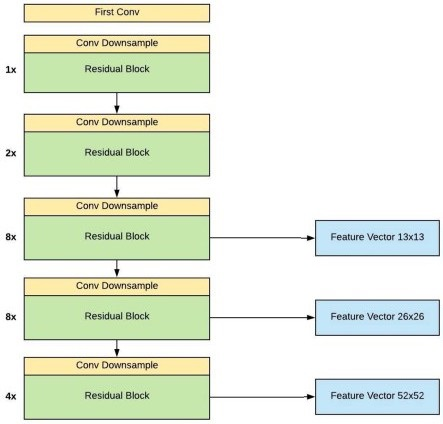

Рисунок 5. Форма выходов сети.

In [ ]:
# Зададим функцию преобразования значений каждого выхода сети к последовательности:
# координаты обекта, ширина и высота ограничивающей рамки, 
# показатель уверенности присутствия объекта и вероятности классов.
def decode(conv_output, i=0):
    # где i = 0, 1 или 2, чтобы соответствовать трем масштабам сетки (выходам сети)
    # форма выхода сети
    conv_shape = tf.shape(conv_output)
    # размер пакета
    batch_size = conv_shape[0]
    # размер выхода сети (13, 26, 52)
    output_size = conv_shape[1]

    # изменяем форму выхода сети, чтобы разделить данные 
    # по трём видам используемых якорей ограничивающих рамок
    # 255 -> (80 + 5) * 3 (как объяснялось выше)
    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + num_classes))

    # Разделяем данные, каждый параметр в свой массив.
    # Смещение центра объекта.
    # Необработанные значения x и y
    conv_raw_dxdy = conv_output[:, :, :, :, 0:2]
    # Предсказанные длинна и ширина ограничивающей рамки
    conv_raw_dwdh = conv_output[:, :, :, :, 2:4]
    # Показатель уверенности что в ограничивающей рамке есть объект
    conv_raw_conf = conv_output[:, :, :, :, 4:5]
    # Веротности присутствия в этой рамке каждого конкретно класса
    conv_raw_prob = conv_output[:, :, :, :, 5: ]

    # Создаём сетку, где output_size равен выходу сети 13, 26, 52.
    # Здесь в комментариях для примера output_size = 13.
    # Создаём вектор в диапазоне от 0 до output_size-1.
    y = tf.range(output_size, dtype=tf.int32) # [0, 1, ... 12]
    # конвертируем в вектор-столбец
    y = tf.expand_dims(y, -1) # [[0], [1], ... [12]]
    # Повторяем вектор output_size раз
    # и получаем матрицу 13 х 13
    # со значениями от 0 до 12 сверху вниз
    y = tf.tile(y, [1, output_size])
    
    # Создаём вектор в диапазоне от 0 до output_size-1
    x = tf.range(output_size, dtype=tf.int32 ) # [0, 1, ... 12]
    # конвертируем в вектор-строку
    x = tf.expand_dims(x, 0) # [[0, 1, ... 12]]
    # Повторяем вектор output_size раз
    # и получаем матрицу 13 х 13
    # со значениями от 0 до 12 слева направо
    x = tf.tile(x, [output_size, 1])

    # Cоздаём в каждой матрице 3 ось
    # и соеденяем 2 матрицы по 3тей оси.
    # Получаем матрицу формы (13, 13, 2),
    # в которой координаты каждого фрагмента сетки.
    xy_grid = tf.concat([x[:, :, tf.newaxis], y[:, :, tf.newaxis]], axis=-1)

    # Преобразовываем сетку к форме (batch_size, 13, 13, 3, 2)
    # чтобы форма совпадала с формой якорей.
    xy_grid = tf.tile(xy_grid[tf.newaxis, :, :, tf.newaxis, :], [batch_size, 1, 1, 3, 1])
    # Приводим к типу float32.
    xy_grid = tf.cast(xy_grid, tf.float32)

    # Используя формулы с рисунка
    # расчитываем координаты центра объекта.
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * yolo_strides[i]
    
    # Вычисляем длину и ширину ограничивающей рамки используя якоря.
    pred_wh = (tf.exp(conv_raw_dwdh) * yolo_anchors[i]) * yolo_strides[i]

    # Соединяем вместе значения координат объекта 
    # и ширины, высоты ограничивающей рамки.
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    # Расчитываем уверенность.
    pred_conf = tf.sigmoid(conv_raw_conf)
    # Вычисляем вероятности классов.
    pred_prob = tf.sigmoid(conv_raw_prob)

    # Соединяем все значения вместе и возвращаем.
    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

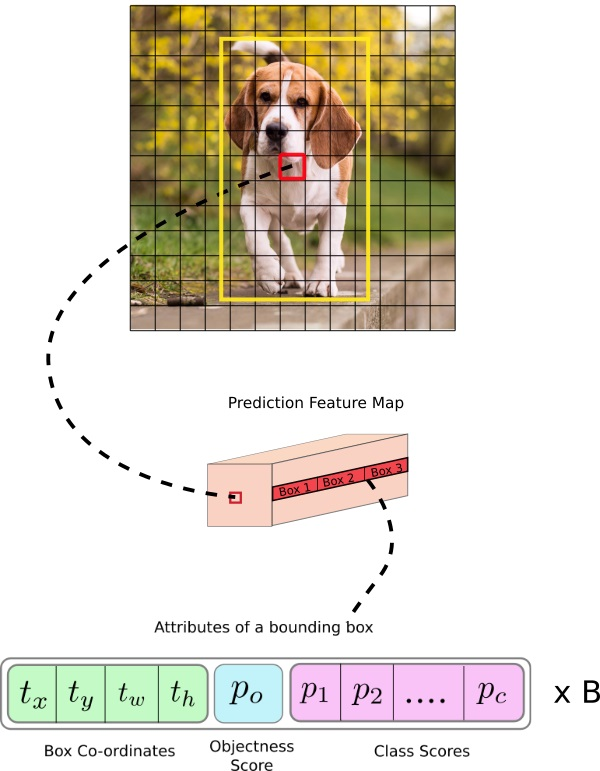

Рисунок 6. Демонстрация значений каждой ячейки сетки изображения.

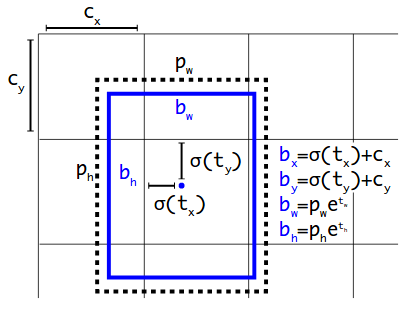

Рисунок 7. Демонстрация вычисления координат, длинны и высоты ограничивающей рамки.

In [ ]:
# Функция для создания модели Yolo
def Create_Yolo(input_size=416, channels=3):
    # Создаём вход модели с формой 416 x 416 x 3.
    input_layer  = Input([input_size, input_size, channels])

    # Добавляем сеть YOLOv3.
    conv_tensors = YOLOv3(input_layer)

    # Создаём список выходных тензоров.
    output_tensors = []

    # Перебираем каждый выход сети,
    for i, conv_tensor in enumerate(conv_tensors):
        # и декодируем его.
        pred_tensor = decode(conv_tensor, i)
        # Добавляем декодированный выход сети.
        output_tensors.append(pred_tensor)

    # Создаём keras модель и возвращаем её.
    Yolo = tf.keras.Model(input_layer, output_tensors)
    return Yolo

In [ ]:
# Функция для загрузки весов в модель.
def load_yolo_weights(model, weights_file):
    # Очищаем сессию чтобы сбросить имена слоёв.
    tf.keras.backend.clear_session()
    # Загружаем оригинальные веса в модель.
    # Yolo имеет 75 свёрточных слоёв.
    range1 = 75 
    # Номера выходных слоёв.
    range2 = [58, 66, 74]   
    
    # Открываем файл с весами модели.
    with open(weights_file, 'rb') as wf:
        # Считываем данные с файла.
        major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

        # Счётчик для слоёв пакетной нормализации.
        j = 0
        # Пербираем слои.
        for i in range(range1):
            
            # Присваиваем имя свёрточному слою и номер по порядку.
            if i > 0:
                conv_layer_name = 'conv2d_%d' %i
            else:
                conv_layer_name = 'conv2d'
                
            # Присваиваем имя слою пакетной нормализации и номер по порядку.
            if j > 0:
                bn_layer_name = 'batch_normalization_%d' %j
            else:
                bn_layer_name = 'batch_normalization'
            
            # Получаем свёрточный слой по имени из модели.
            conv_layer = model.get_layer(conv_layer_name)
            # Из слоя получаем параметры:
            # количество фильтров
            filters = conv_layer.filters
            # размер ядра свёртки
            k_size = conv_layer.kernel_size[0]
            # размер входа слоя
            in_dim = conv_layer.input_shape[-1]

            # Если текущий слой не выходной (используется пакетная нормализация).
            if i not in range2:
                # Считываем с файла парамметры слоя пакетной нормализации.
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
                # В фреймворке darknet используется следующий порядок параметров:
                # [beta, gamma, mean, variance].

                # Мы же используем tensorflow, в котором другой
                # порядок следования: [gamma, beta, mean, variance].
                # Изменяем форму и порядок следования.
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
                
                # Получаем слой пакетной нормализации по имени из модели.
                bn_layer = model.get_layer(bn_layer_name)
                # Увеличиваем счётчик слоёв пакетной нормализации.
                j += 1 
            else:
                # Если слой без батч нотмализации, значит в слое
                # используются нейроны смещения.
                # Считываем значения весов для смещения.
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

            # В фреймворке Darknet используется форма
            # свёрточного слоя: (out_dim, in_dim, height, width).
            # В tensorflow: (height, width, in_dim, out_dim)

            # Объявляем кортеж с параметрами формы свёрточного слоя.
            conv_shape = (filters, in_dim, k_size, k_size)

            # Считываем с файла все значения весов слоя.
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
            # Изменяем форму и порядок следования.
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

            if i not in range2:
                # Если слой не выходной,
                # устанавливаем значения весов в слой модели.
                # Устанавливаем веса свёрточного слоя.
                conv_layer.set_weights([conv_weights])
                # Устанавливаем веса слоя пакетной нормализации.
                bn_layer.set_weights(bn_weights)
            else:
                # Если слой выходной,
                # устанавливаем значения весов свёртки и смещения.
                conv_layer.set_weights([conv_weights, conv_bias])

        # Проверяем пустой ли файл с весами.
        assert len(wf.read()) == 0, 'Failed to read all data'

Мы задали все неоходимые функции для построения сети. Теперь зададим функции предобработки входного изображения, постобработки и фильрации выходного массива ограничивающих рамок.

In [ ]:
# Функция предобработки входного изображения.
# image - входное изображение.
# target_size - необходимый размер.

# Сеть на вход ожидает квадратное изображение
# размером 416 х 416 х 3.
# Однако размеры и форма входных изображений могут быть другими.
# Для этого изменим размер изображения к необходимому
# не изменяя пропорции. Если изображение прямогуольное,
# то расположим его по центру, а края заполним серым цветом.

def image_preprocess(image, target_size):
    # Размеры, к которым нужно привести изображение.
    ih, iw    = target_size
    # Текущие размеры изображения.
    h,  w, _  = image.shape

    # Расчитываем масштаб изменения размера.
    scale = min(iw/w, ih/h)
    # Умножаем значение ширины и высоты изображения на масштаб.
    nw, nh  = int(scale * w), int(scale * h)
    # Изменяем размер изображения к необходимому.
    image_resized = cv2.resize(image, (nw, nh))

    # Создаём пустое изображение, заполненое серым цветом.
    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)

    # Расчитываем координаты куда копировать масштабированное
    # изображение, чтобы оно было по центру.
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    
    # Копируем масштабированное изображение в пустое серое.
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized

    # Полученное изображение переводим в тип данных float32.
    image_paded = image_paded.astype(np.float32)
    
    # Приводим значения интенсивности пикселей 
    # к диапазону от 0 до 1.
    image_paded = image_paded / 255.0

    # Возвращаем преобразованное изображение.
    return image_paded

In [ ]:
# Функция постобработки и фильтрации ограничивающих рамок и объектов.
# pred_bbox - массив необработанных ограничивающих рамок после предсказания.
# original_image - оригинальное изображение.
# input_size - размер входа сети.
# score_threshold - порог фильтрации объектов с низкой верояностью

def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    # Преобразуем тензор в массив numpy
    pred_bbox = np.array(pred_bbox)

    # Разделяем массив по значениям.
    # Координаты центра, длинна и ширина ограничивающей рамки.
    pred_xywh = pred_bbox[:, 0:4]
    # Показатель уверенности что в ограничивающей рамке есть объект.
    pred_conf = pred_bbox[:, 4]
    # Веротности присутствия в этой рамке каждого конкретно класса.
    pred_prob = pred_bbox[:, 5:]

    # Изменяем формат ограничивающих рамок.
    # (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    # xmin = x - w/2, ymin = y - h/2
    # xmax = x + w/2, ymax = y + h/2
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    
    # Сеть расчитывает размеры ограничивающих рамок 
    # отностительно размера своего входа = 416 х 416.
    # Нам нужно масштабировать размеры ограничивающих рамок
    # относительно изначального размера оригинального изображения.
    # (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org).
    # То есть производим изменения обратные функции image_preprocess.

    # Исходные размеры оригинального изображения.
    org_h, org_w = original_image.shape[:2]
    # Масштаб изменения размера.
    resize_ratio = min(input_size / org_w, input_size / org_h)

    # Вычисляем на сколько было сдвинуто изображение
    # по оси х (там, где заполнено серым).
    dw = (input_size - resize_ratio * org_w) / 2
    # На сколько сдвинуто по оси y.
    dh = (input_size - resize_ratio * org_h) / 2

    # Масштабируем значения координат оси х и убираем сдвиг.
    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    # Масштабируем значения координат оси y и убираем сдвиг.
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # Ограничиваем значения рамок, которые вышли  
    # за пределы границ изображения.
    # max([xmin, ymin], [0, 0])
    # min([xmax, ymax], [org_w - 1, org_h - 1])
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    
    # Зададим маску неправильных ограничивающих рамок.
    # Условие: xmin > xmax или ymin > ymax
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    # Присвоим 0 значениям, которые подпадают под условие маски.
    pred_coor[invalid_mask] = 0

    # Зададим допустимый диапазон масштабов рамок.
    valid_scale=[0, np.inf]

    # Вычислим масштаб каждой ограничивающей рамки.
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    # Создадим маску по масштабу с условием, 
    # чтобы масштаб рамки был в допустимом диапазоне.
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # Находим класс объекта в каждой ограничивающей рамке.
    # 80 one hot encoding - > 1 index.
    classes = np.argmax(pred_prob, axis=-1)

    # Вычисляем итоговую вероятность объектов в ограничивающих рамках.
    # Умножаем показатель уверенности присутствия объекта в ограничивающей рамке
    # на вероятность класса, который имеет максимальную вероятность в этой рамке.
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    
    # Создадим маску по вероятности с условием, 
    # чтобы верояность была выше допустимого порога.
    score_mask = scores > score_threshold

    # Создадим общую маску по масштабу и по вероятности.
    mask = np.logical_and(scale_mask, score_mask)

    # Отбрасываем недопустимые ограничивающие рамки по условию общей маски.
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    # Соединяем всё в один массив и возвращаем.
    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

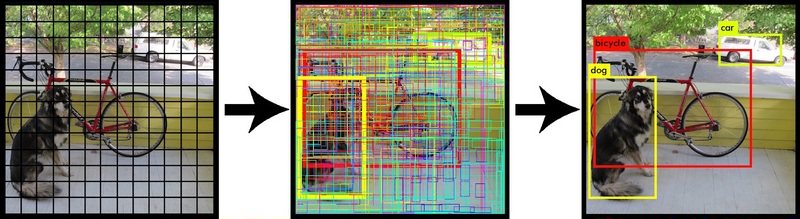

Рисунок 8. Демонстрация постобработки и фильтрации ограничивающих рамок.

In [ ]:
# Функция для расчёта соотношения пересечения 
# двух ограничиващих рамок.
def bboxes_iou(boxes1, boxes2):
    # Преобразуем ограничивающие рамки в numpy массив
    # для удобной индексации.
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    # Вычисляем площади каждой ограничивающей рамки.
    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    # Вычисляем какой ограничивающей рамки выбрать левый верхний угол.
    # max((xmin1, ymin1), (xmin2, ymin2))
    left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
    # Вычисляем какой ограничивающей рамки выбрать правый нижний угол.
    # min((xmax1, ymax1), (xmax2, ymax2))
    right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    # Проверяем пересекаются ли рамки.
    # (xmax, ymax) - (xmin, ymin)
    inter_section = np.maximum(right_down - left_up, 0.0)

    # Расчитываем площадь пересечения.
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    # Вычисляем площадь объединения.
    union_area    = boxes1_area + boxes2_area - inter_area

    # Вычисляем Коэффициент Жаккара - соотношение пересечения по отношению к объединению.
    # Если полощадь пересечения будет очень маленькая, 
    # а площадь объединения очень большая, то при делении
    # мы можем получить крайне маленькое число.
    # Чтобы избежать проблем с вычислениями выбираем максимальное между
    # получившимся значением и машинный нулём для типа данных float32.
    ious = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    # Возвращаем расчитанный коэффициент Жаккара.
    return ious

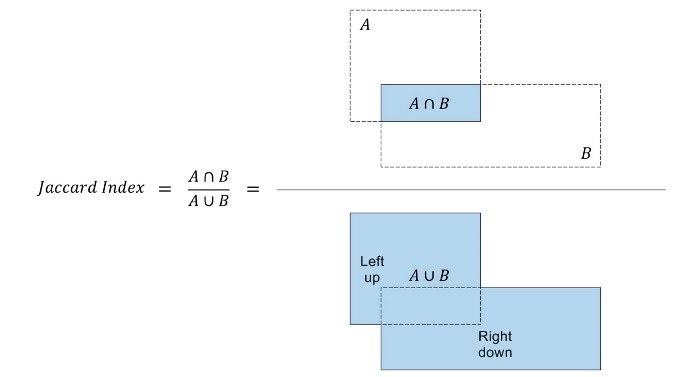

Рисунок 9. Демонстрация расчёта Коэффициента Жаккара - соотношение пересечения по отношению к объединению.

In [ ]:
# Сеть после предсказния выдаёт много разных рамок 
# одного и того же объекта с разной вероятностью.
# Чтобы выбрать наиболее подходящую и избавиться 
# от остальных используют алгоритм Non-maximum Suppression (NMS).

# Функция подавления не-максимумов позволяет отфильтровать
# менее вероятные ограничивающие рамки одних и тех же объектов.

# bboxes - рамки формата (xmin, ymin, xmax, ymax, score, class).
# iou_threshold - порог пересечения.

def nms(bboxes, iou_threshold):

    # Создадим список классов в данном изображении.
    classes_in_img = list(set(bboxes[:, 5]))

    # Список наилучших ограничивающих рамок с наибольшими вероятностями.
    best_bboxes = []

    # Перебираем все классы на изображении.
    for cls in classes_in_img:
        # Выбираем все ограничивающие рамки с текущим классом.
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        # Пока список ограничивающих рамок текущего класса не станет пустым.
        while len(cls_bboxes) > 0:
            
            # Выбираем ограничивающую рамку с наивысшей вероятностью.
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]

            # Добавляем эту рамку в список наилучших.
            best_bboxes.append(best_bbox)

            # Создаём массив рамок текущего класса без наилучшей.
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            
            # Рассчитываем соотношение пересечения наилучшей ограничивающей
            # рамки с отальными рамками этого класса.
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])

            # Создаём массив весовых коэффициентов заполненный единицами.
            weight = np.ones((len(iou),), dtype=np.float32)

            # Зануляем весовой коэффициент тех рамок, у которых 
            # сооношение пересечения больше допустимого порога.
            iou_mask = iou > iou_threshold
            weight[iou_mask] = 0.0

            # Умножаем вероятность каждой рамки на её 
            # весовой коэффициент (0 или 1).
            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            
            # Оставляем те рамки, вероятность которых больше 0.
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    # Возвращаем список наилучших ограничивающих рамок.
    return best_bboxes

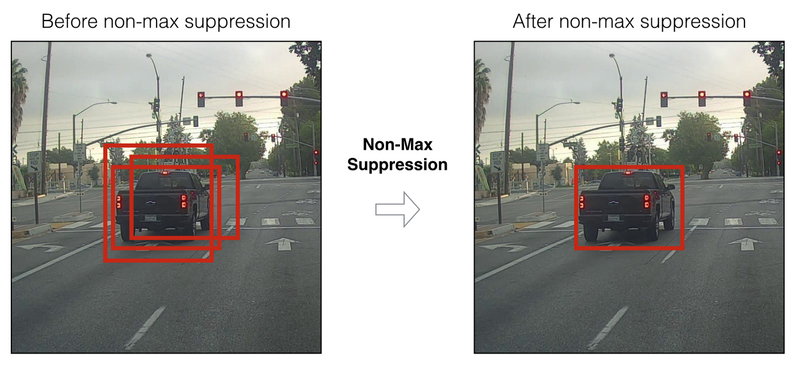

Рисунок 10. Демонстрация работы алгоритма подавления не-максимумов.

In [ ]:
# Функция для рисования ограничивающих рамок
# и меток класса на изображении.

# image - изображение.
# bboxes - список ограничивающих рамок.
# show_label - нужно показывать метки или нет.
# show_confidence - отображение вероятности.
# text_color - цвет текста меток.
# rectangle_colors - цвета ограничивающих рамок.

def draw_bbox(image, bboxes, show_label=True, show_confidence = True, text_color='', rectangle_colors=''):   

    # Сохраняем размер изображения.
    image_h, image_w, image_ch = image.shape

    # Используем цветовое пространство hsv (Hue, Saturation, Value)
    # чтобы задать цвет класса объекта ограничивающей рамки.
    # Цвет задаётся Hue от 0 до 1, насыщенность и яркость берём максимально.
    # Присваиваем каждому классу свой цвет.
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]

    # Преобразовывем цвета из пространства hsv в rgb.
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    # Фиксируем зерно генератора случайных чисел,
    # чтобы каждый раз цвета перемешивались 
    # в одном и том же порядке.
    random.seed(0)
    # Перемешиваем цвета.
    random.shuffle(colors)
    # Снимаем фиксацию генератора случайных чисел.
    random.seed(None)

    # Перебираем ограничивающие рамки.
    for i, bbox in enumerate(bboxes):
        # Разделяем на координаты рамки,
        coor = np.array(bbox[:4], dtype=np.int32)
        # вероятность класса и
        score = bbox[4]
        # индекс класса.
        class_ind = int(bbox[5])

        # Выбираем использовать заданые извне цвета ограничивающих 
        # прямоугольников или со списка сгенерированных цветов.
        if rectangle_colors != '':
            bbox_color = rectangle_colors 
        else:
            bbox_color = colors[class_ind]

        # Выбираем использовать заданый извне цвет текста 
        # меток или со списка сгенерированных цветов.
        # Чтобы лучше было видно цвет текста сделаем
        # инвертированным относительно цвета рамки.
        if text_color != '':
            label_color = text_color
        else:
            r, g, b = colors[class_ind]
            label_color = (255 - r, 255 - g, 255 - b)

        # Расчитываем ширину линии прямоугольника 
        # исходя из размеров изображения.
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        # Если ширина линии оказалась меньше 1, 
        # то повышаем значение до единицы.
        if bbox_thick < 1: 
            bbox_thick = 1

        # Расчитываем размер шрифта.
        fontScale = 0.75 * bbox_thick

        # Распаковываем значения координат.
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # Рисуем ограничивающий прямоугольник объекта на изображении.
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        # Если установлен флаг отображения меток.
        if show_label:
            
            # Если нужно показывать вероятность.
            # Преобразовываем значение вероятности в строку.
            if show_confidence:
                score_str = " {:.2f}".format(score) 
            else:
                score_str = ""
            
            # Форимируем метку класса и вероятности.
            label = "{}".format(class_names_list[class_ind]) + score_str

            # Получаем размеры прямоугольника, который займёт текст.
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # Рисуем заполненный прямоугольник для текста метки.
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # Пишем текст метки поверх прямоугольника.
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, label_color, bbox_thick, lineType=cv2.LINE_AA)

    # Возвращаем изображение с нарисованными ограничивающими рамками и вероятностями объектов.
    return image

In [ ]:
# Функция обнаружения объектов на изображении с помощью Yolo.

# Yolo - модель сети.
# image_path - путь к изображению.
# input_size - размер входа сети (к этому размеру нужно привести входное изображение)
# score_threshold - порог вероятности предсказанного класса ! проверить
# iou_threshold - порог пересечения правильной ограничивающей рамки с предсказанной
# rectangle_colors - цвета ограничивающих рамок

def detect_image(Yolo, image_path, input_size=416, score_threshold=0.3, iou_threshold=0.45, text_color='', rectangle_colors=''):
    
    # Считываем изображение.
    original_image = cv2.imread(image_path)
    # По умолчанию opencv сохраняет изображение в формате BGR, 
    # а сеть принимает изображения в формате RGB.
    # Конвертируем изображение в формат RGB.
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    # Производим предобработку входного изображения.
    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    # В полученное изображение добавляем одну ось для передачи в модель.
    image_data = image_data[np.newaxis, ...]

    # Передаём предобработанное изображение на вход сети,
    # на выходе получаем предсказанные сетью
    # объекты с ограничивающими рамками.
    pred_bbox = Yolo.predict(image_data)
    # После предсказания в переменной pred_bbox 
    # находится список с тремя массивами,
    # каждый соответствует выходу сети.
    # Вот форма этих массивов:
    # (1, 52, 52, 3, 85)
    # (1, 26, 26, 3, 85)
    # (1, 13, 13, 3, 85)
       
    # Далее мы объединяем все ограничивающие рамки каждого выхода.
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    # Новая форма массивов в списке pred_bbox:
    # (8112, 85)
    # (2028, 85)
    # (507, 85)

    # Теперь мы объединяем ограничивающие рамки по всем выходам в один тензор.
    pred_bbox = tf.concat(pred_bbox, axis=0)
    # Форма тензора (10647, 85). 10647 = 8112 + 2028 + 507

    # Производим постобработку объектов с ограничивающими рамками.   
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    # После постобработки выходной массив bboxes 
    # будет иметь форму (кол-во_рамок, 6).

    # Отфильтровываем лишние ограничивающие рамки с помощью подавления не-максимумов.
    bboxes = nms(bboxes, iou_threshold)

    # Рисуем ограничивающие рамки объектов на входном изображении.
    image = draw_bbox(original_image, bboxes, text_color=text_color, rectangle_colors=rectangle_colors)
    
    # Возвращаем изменённое изображение.
    return image

Имея все необходимые инструменты построим сеть, загрузим в неё веса и протестируем на наших примерах.

In [ ]:
# Создаём модель сети Yolo.
yolo = Create_Yolo(input_size=yolo_input_size)
# Загружаем предобученные оригинальные веса в модель.
load_yolo_weights(yolo, yolo_weights_path)

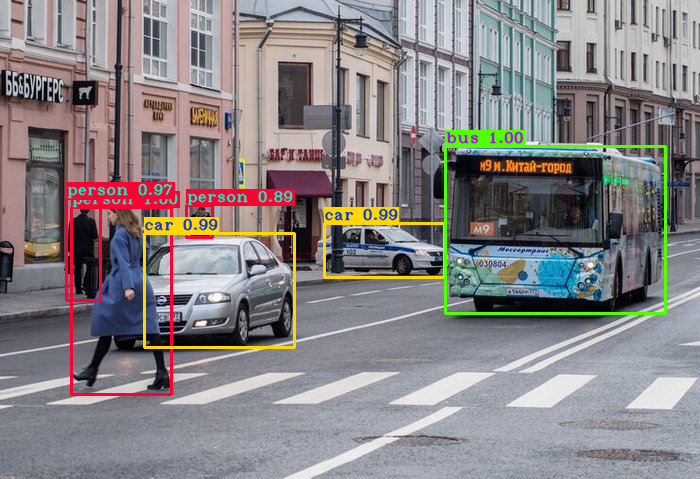

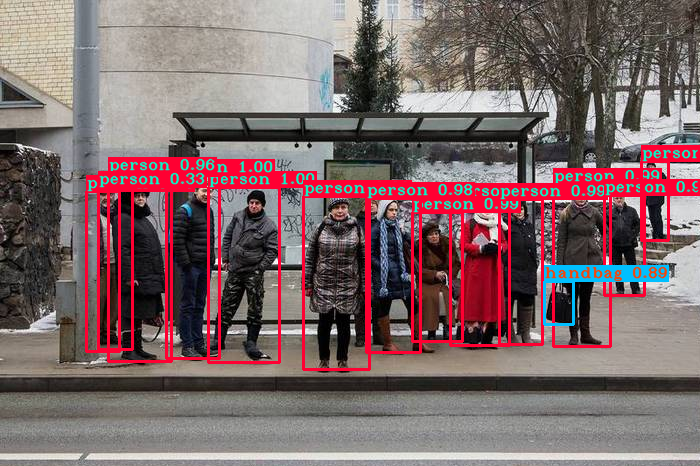

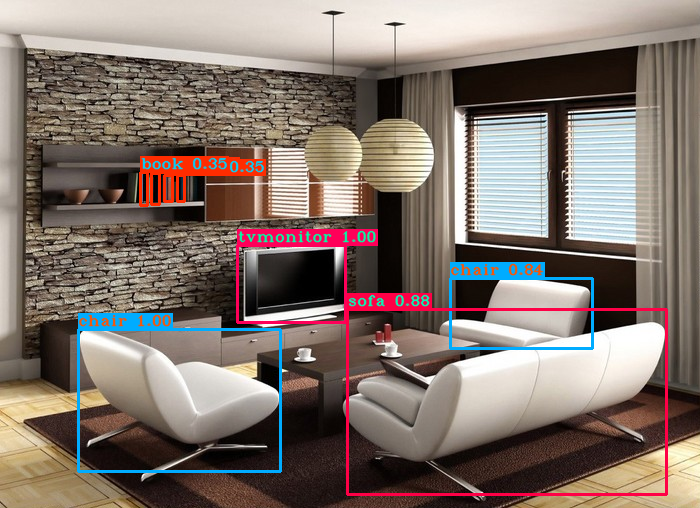

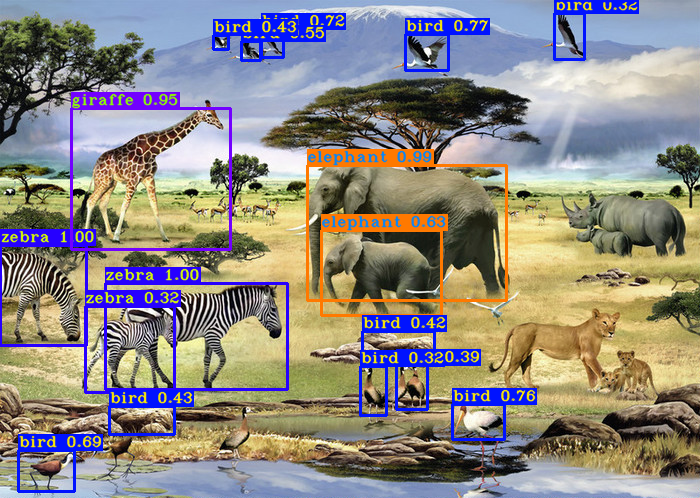

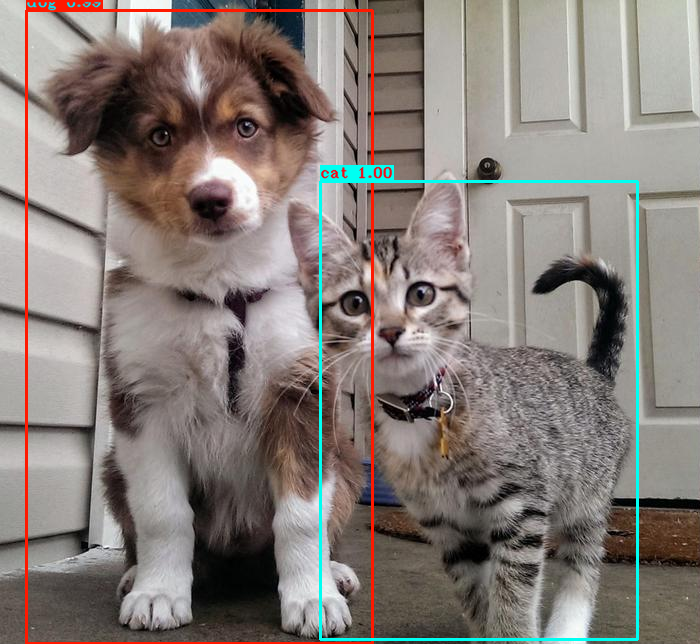

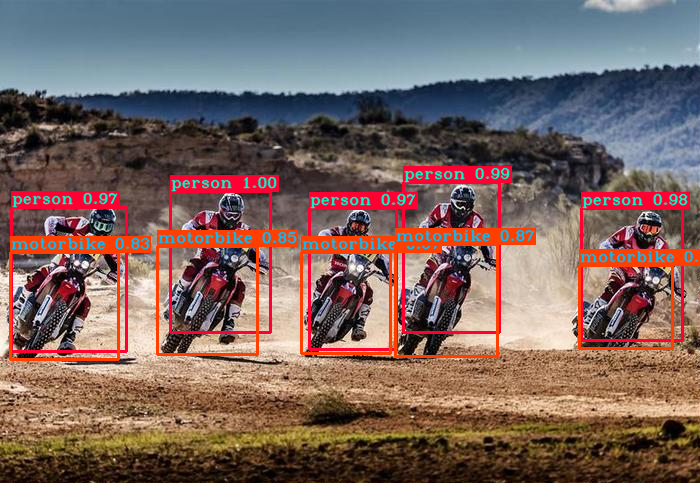

In [ ]:
# Загрузим список наши примеров изображений.
demo_dir = 'Demo_images'
images_path_list = [f for f in listdir(demo_dir) if isfile(join(demo_dir, f))]
images_path_list.sort()

# Подадим на вход сети каждое изображение и 
# отобразим ограничивающие рамки найденных обектов.
for image_path in images_path_list:
    # Путь к изображению.
    image_path = join(demo_dir, image_path)

    # Вариант отображения ограничивающих рамок:
    # Каждый класс имеет свой цвет ограничивающей рамки.
    image = detect_image(yolo, image_path, input_size=yolo_input_size)

    # Все объекты помечаются синей ограничивающей рамкой с белым текстом.
    # image = detect_image(yolo, image_path, input_size=yolo_input_size, text_color=(255, 255, 255), rectangle_colors=(255, 0, 0))
    
    # Отобразим выходное изображение.
    cv2_imshow(image)

#Литература

1. https://pjreddie.com/darknet/yolo/
2. https://pjreddie.com/media/files/papers/YOLOv3.pdf
3. https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg
4. https://becominghuman.ai/understanding-anchors-backbone-of-object-detection-using-yolo-54962f00fbbb
5. https://cocodataset.org/#home